In [26]:
filename = 'diabetes.csv'
import pandas as pd
import numpy as np

df = pd.read_csv(filename)
df = df.astype(float)

train = df.sample(frac=0.8, random_state=105)
test = df.drop(train.index)
print(df.head())

     6    148    72    35      0  33.6  0.627    50    1
0  1.0   85.0  66.0  29.0    0.0  26.6  0.351  31.0  0.0
1  8.0  183.0  64.0   0.0    0.0  23.3  0.672  32.0  1.0
2  1.0   89.0  66.0  23.0   94.0  28.1  0.167  21.0  0.0
3  0.0  137.0  40.0  35.0  168.0  43.1  2.288  33.0  1.0
4  5.0  116.0  74.0   0.0    0.0  25.6  0.201  30.0  0.0


In [27]:
#test
print(len(train), len(test))

614 153


In [28]:
df.describe()

,6,148,72,35,0,33.6,0.627,50,1
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,3.842243,120.859192,69.101695,20.517601,79.903520,31.990482,0.471674,33.219035,0.348110
std,3.370877,31.978468,19.368155,15.954059,115.283105,7.889091,0.331497,11.752296,0.476682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243500,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,32.000000,32.000000,0.371000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,127.500000,36.600000,0.625000,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [29]:
#test
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   6       767 non-null    float64
 1   148     767 non-null    float64
 2   72      767 non-null    float64
 3   35      767 non-null    float64
 4   0       767 non-null    float64
 5   33.6    767 non-null    float64
 6   0.627   767 non-null    float64
 7   50      767 non-null    float64
 8   1       767 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


array([[<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'148'}>,
        <AxesSubplot:title={'center':'72'}>],
       [<AxesSubplot:title={'center':'35'}>,
        <AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'33.6'}>],
       [<AxesSubplot:title={'center':'0.627'}>,
        <AxesSubplot:title={'center':'50'}>,
        <AxesSubplot:title={'center':'1'}>]], dtype=object)

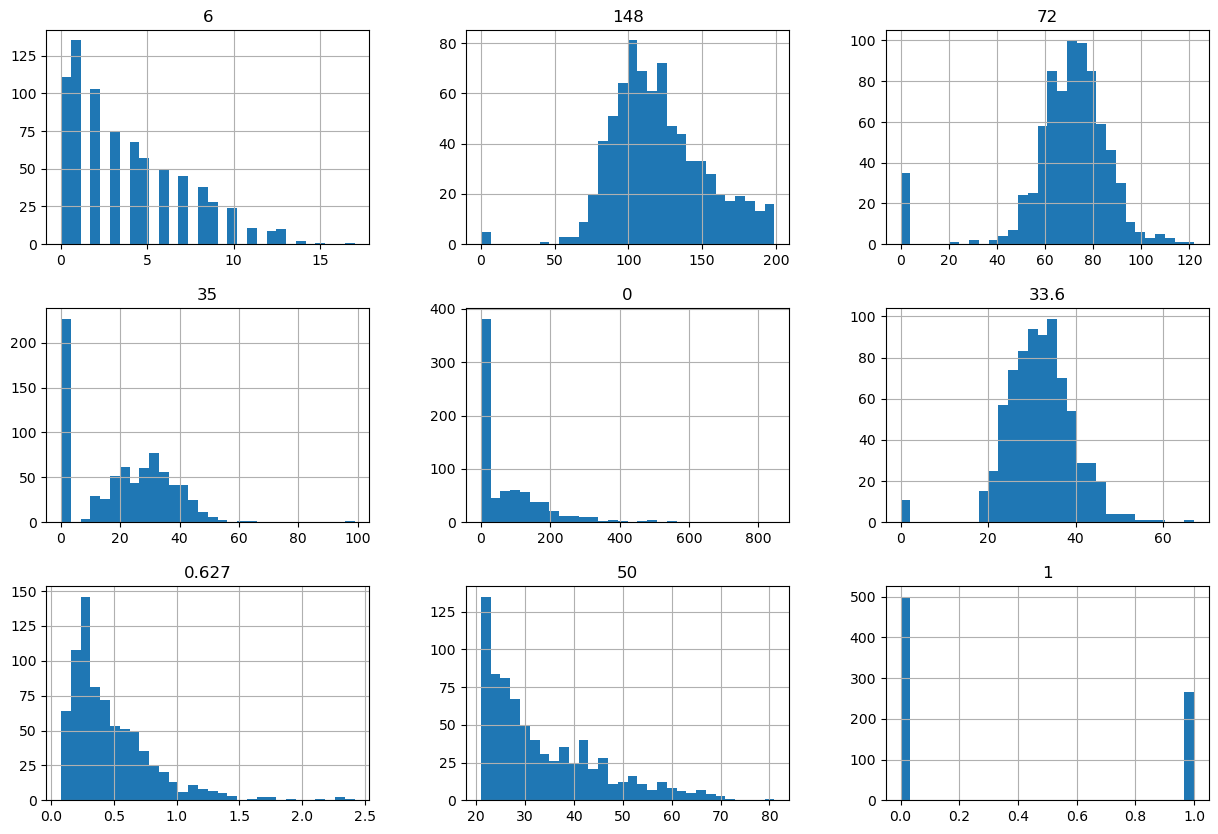

In [30]:
#test
df.hist(bins=30, figsize=(15,10))

In [31]:
#Train model
outcome_group = train.groupby(df.columns[-1])
n_attr = len(df.columns) - 1

print(n_attr) #test

summaries = {}

for classValue, instances in outcome_group:
    attr_mv = []
    mean = list(instances.mean(axis=0).values)
    stdev = list(instances.std(axis=0).values)
    
    for i in range(n_attr):
        attr_mv.append([mean[i], stdev[i]])
        
    summaries[classValue] = attr_mv
    
    print(mean[0]) #test
    
from pprint import pprint #test
pprint(summaries) #test

8
3.2896039603960396
4.766666666666667
{0.0: [[3.2896039603960396, 3.0378572247064852],
       [110.16831683168317, 25.004047039945252],
       [67.97524752475248, 17.618211342424093],
       [19.849009900990097, 14.966446309872762],
       [69.43069306930693, 95.56208353704038],
       [30.350000000000023, 7.906445842227682],
       [0.4308465346534652, 0.29344110752581426],
       [31.094059405940595, 11.620810645390256]],
 1.0: [[4.766666666666667, 3.6138798529705616],
       [141.78095238095239, 33.11744533763893],
       [72.01904761904763, 19.986589260922006],
       [23.166666666666668, 16.872044014241464],
       [103.60952380952381, 140.61393039391524],
       [35.35238095238094, 7.208482446696007],
       [0.5614809523809524, 0.3477006110815122],
       [37.08571428571429, 10.782862786390718]]}


In [32]:
import math
def calculateProb(x, mean, stdev):
    exponent = math.exp(-math.pow(x-mean, 2) / (2*math.pow(stdev, 2)))
    return (1 / (math.sqrt(2*math.pi) * math.pow(stdev, 2))) * exponent

def calculateClassProb(summaries, X_vec):
    probabilities = {}
    for classValue, classSummaries in summaries.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, stdev = classSummaries[i]
            x = X_vec[i]
            probabilities[classValue] *=calculateProb(x, mean, stdev)
    return probabilities

def predict(summaries, X_vec):
    prob = calculateClassProb(summaries, X_vec)
    bestLabel, bestProb = None, -1
    for classValue, probability in prob.items():
        if bestLabel is None or probability > bestProb:
            bestProb = probability
            bestLabel = classValue
    return bestLabel

In [33]:
predictions = []
testSet = test.values.tolist()
for i in range(len(testSet)):
    result = predict(summaries, testSet[i])
    predictions.append(result)

In [34]:
def getAccuracy(test, predictions):
    correct = 0
    for i in range(len(test)):
        if test.iloc[i, -1] == predictions[i]:
            correct+=1
    return (correct/float(len(testSet))) * 100.0

accuracy = getAccuracy(test, predictions)
print(f'Split {len(df)} rows into train={len(train)} and test={len(test)}')
print(f'Accuracy: {accuracy}')

Split 767 rows into train=614 and test=153
Accuracy: 74.50980392156863


# Using Sci kit learn

In [36]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
data_train = train.iloc[:, :-1]
target_train = train.iloc[:, -1]
gnb.fit(data_train, target_train)

data_test = test.iloc[:, :-1]
y_pred = gnb.predict(data_test)

from sklearn import metrics
print(f'Split {len(df)} rows into train={len(data_train)} and test={len(data_test)}')
print("Accuracy: ", (metrics.accuracy_score(test.iloc[:, -1], y_pred)*100))

Split 767 rows into train=614 and test=153
Accuracy:  74.50980392156863
